# Jumping with impedance control

In [1]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from  mpl_toolkits.mplot3d import Axes3D

use_real_robot_computer = False
use_real_robot = False


if use_real_robot_computer:
    from nyu_finger import NYUFingerReal
    from nyu_finger_sim.nyu_finger_simulator import NYUFingerSimulator
else:
    from nyu_finger_simulator import NYUFingerSimulator


import robot_kinematics

In [2]:
# we create a robot simulation
if use_real_robot:
    robot = NYUFingerReal()
    robot.initialize('enp5s0f1')
else:
    robot = NYUFingerSimulator(fixedBase=False)
    # we reset the simulation to the initial position we want to move
    robot.reset_state(np.array([0.0,0.0,0.1]))

## Getting the robot to jump
The goal of this notebook is to use an impedance controller to get the robot to jump with an impedance controller.
We now allow the robot to move along the y axis (as if it was attached on a rail such that it cannot move in any other direction). But the robot can fall on the ground.

## Questions
1. Write an impedance controller with desired set point $p_0 = [0.3,-0.2,0.014]$, stiffness $K = [300,300,300]$ and damping $D = [5, .1, 5]$. Run the simulation from the beginning (when the robot is dropped from above). What do you observe? Is it what you would expect? How is the motion of the robot changing when you change the stiffness in the y direction? and the damping?

2. Use a time varying setpoint for the vertical (y) direction, such that $y_{ref} = -0.2 + 0.1\sin(\omega t)$, with $\omega = 2\pi$. What is the behavior of the robot that you observe? (plot the position and velocity of the foot vs. the desired position). In these experiments, use $D = [5, .1, 5]$

3. Change the amplitude of the sine wave and its frequency and try to get parameters to jump as high as possible. What parameters did you find? What else could you do to get the robot to jump higher? (only describe what you think would help - assuming that you can do anything you like with the robot).

4. (optional) Try to do the same motion of the foot with the velocity-based controller you wrote in Lab5. What do you observe? In your opinion, why are the behaviors different?

In [3]:
# # we simulate for 6 seconds
# robot.reset_state(np.array([0.0,0.0,0.1]))
# run_time = 6.
# dt = 0.001
# num_steps = int(run_time/dt)

# # we create our kinematic object
# kin = robot_kinematics.robot_kinematics()

# # we create arrays to store information
# measured_joint_positions = np.zeros([num_steps,3]) # will store the measured position
# measured_joint_velocities = np.zeros_like(measured_joint_positions) # will store the measure velocities

# desired_torques = np.zeros_like(measured_joint_positions) # will store the commands we send to the robot

# simulation_time = np.zeros([num_steps]) # will store the running time

# # we will store the foot positions and velocities
# foot_measured_position = np.zeros([num_steps,3])
# foot_measured_velocity = np.zeros([num_steps,3])
# foot_desired_position = np.zeros([num_steps,3])
# foot_desired_velocity = np.zeros([num_steps,3])

# K_x = 300
# K_y = 300
# K_z = 300

# K = np.array([[K_x, 0, 0],
#               [0, K_y, 0],
#               [0, 0, K_z]])

# D_x = 5
# D_y = 0.1
# D_z = 5

# D = np.array([[D_x, 0, 0],
#               [0, D_y, 0],
#               [0, 0, D_z]])

# p_0 = np.array([[0.3],[-0.2],[0.014]])

# q = np.array([[0],[0],[0]])

# # now we can enter the main control loop (each loop is 1 control cycle)
# for i in range(num_steps):

#     # get the current time and store it
#     simulation_time[i] = dt * i
    
#     # we get the position and velocities of the joints and save them
#     q, dq = robot.get_state()
#     measured_joint_positions[i,:] = q
#     measured_joint_velocities[i,:] = dq
        
#     foot_desired_position[i,:] = np.reshape(p_0, (1,3))
    
#     # save the current position of the foot using the FK function    
#     kin.update_kinematics(q)
#     foot_measured_position[i,:] = kin.TS_F[0:3,3]

#     jacobian = kin.orientedJ[3:6,:]    
#     foot_measured_velocity[i,:] = jacobian.dot(dq)

#      ###WRITE THE CONTROLLER HERE
#     joint_torques = np.array([0,0,0])
    
#     joint_torques = np.transpose(jacobian)@((K@(p_0-np.reshape(foot_measured_position[i],(3, 1)))) - (D@np.reshape(foot_measured_velocity[i],(3, 1))))
    
#     desired_torques[i,:] = np.reshape(joint_torques,(1, 3))
    
#     # we send them to the robot and do one simulation step
#     robot.send_joint_torque(joint_torques)
#     robot.step()

In [4]:
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

def plot_foot_trajectory(time, foot_pos, foot_pos_des, foot_vel, foot_vel_des):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    x_pos = foot_pos[:,0]
    y_pos = foot_pos[:,1]
    z_pos = foot_pos[:,2]
    
    x_vel = foot_vel[:,0]
    y_vel = foot_vel[:,1]
    z_vel = foot_vel[:,2]
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.plot(x_pos,y_pos)
    plt.plot(foot_pos_des[:,0], foot_pos_des[:,1])
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.subplot(1,2,2)
    plt.plot(x_pos,z_pos)
    plt.plot(foot_pos_des[:,0], foot_pos_des[:,2])
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time, x_pos, time, foot_pos_des[:,0])
    plt.ylabel('foot x position [m]')
    plt.subplot(3,1,2)
    plt.plot(time, y_pos, time, foot_pos_des[:,1])
    plt.ylabel('foot y position [m]')
    plt.subplot(3,1,3)
    plt.plot(time, z_pos, time, foot_pos_des[:,2])
    plt.ylabel('foot z position [m]')
    plt.xlabel('Time [s]')
    
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time, x_vel, time, foot_vel_des[:,0])
    plt.ylabel('foot x velocity [m]')
    plt.subplot(3,1,2)
    plt.plot(time, y_vel, time, foot_vel_des[:,1])
    plt.ylabel('foot y velocity [m]')
    plt.subplot(3,1,3)
    plt.plot(time, z_vel, time, foot_vel_des[:,2])
    plt.ylabel('foot z velocity [m]')
    plt.xlabel('Time [s]')

# plot_foot_trajectory(simulation_time, foot_measured_position, foot_desired_position, foot_measured_velocity, foot_desired_velocity)

# Q2

In [5]:
# we simulate for 6 seconds
robot.reset_state(np.array([0.0,0.0,0.1]))
run_time = 6.
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we create arrays to store information
measured_joint_positions = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities = np.zeros_like(measured_joint_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_joint_positions) # will store the commands we send to the robot

simulation_time = np.zeros([num_steps]) # will store the running time

# we will store the foot positions and velocities
foot_measured_position = np.zeros([num_steps,3])
foot_measured_velocity = np.zeros([num_steps,3])
foot_desired_position = np.zeros([num_steps,3])
foot_desired_velocity = np.zeros([num_steps,3])

K_x = 300
K_y = 500
K_z = 300

K = np.array([[K_x, 0, 0],
              [0, K_y, 0],
              [0, 0, K_z]])

D_x = 5
D_y = 0.1
D_z = 5

D = np.array([[D_x, 0, 0],
              [0, D_y, 0],
              [0, 0, D_z]])

p_0 = np.array([[0.3],[-0.2],[0.014]])

q = np.array([[0],[0],[0]])

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i
    
    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_joint_positions[i,:] = q
    measured_joint_velocities[i,:] = dq
        
    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    foot_measured_position[i,:] = kin.TS_F[0:3,3]

    jacobian = kin.orientedJ[3:6,:]    
    foot_measured_velocity[i,:] = jacobian.dot(dq)
    
    a = 0.13
    w = 2*np.pi
    
    x_ref = np.array([[0.3],[-0.2 + a*np.sin(w*simulation_time[i])],[0.014]])
    x_ref_tdev = np.array([[0.],[0.1*w*np.cos(w*simulation_time[i])],[0.]])

    foot_desired_position[i,:] = np.reshape(x_ref, (1,3))
    foot_desired_velocity[i,:] = np.reshape(x_ref_tdev, (1,3))
    
     ###WRITE THE CONTROLLER HERE
    joint_torques = np.array([0,0,0])
    
    joint_torques = np.transpose(jacobian)@((K@(x_ref-np.reshape(foot_measured_position[i],(3, 1)))) + (D@(x_ref_tdev - np.reshape(foot_measured_velocity[i],(3, 1)))))
    
    desired_torques[i,:] = np.reshape(joint_torques,(1, 3))
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


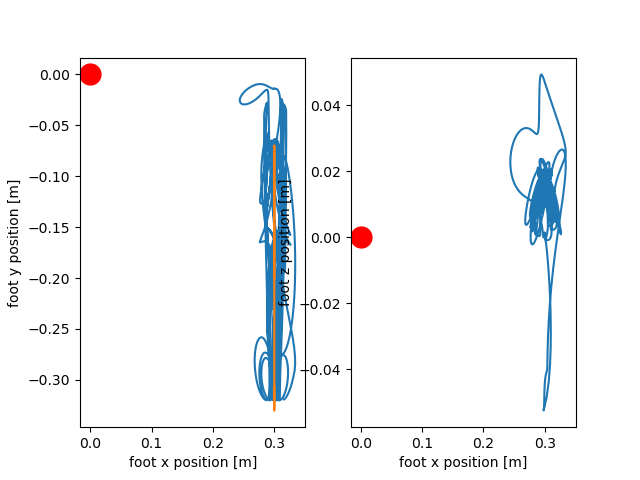

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


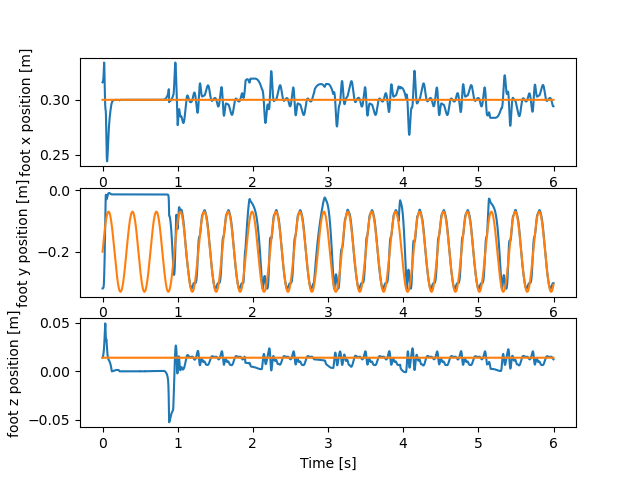

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


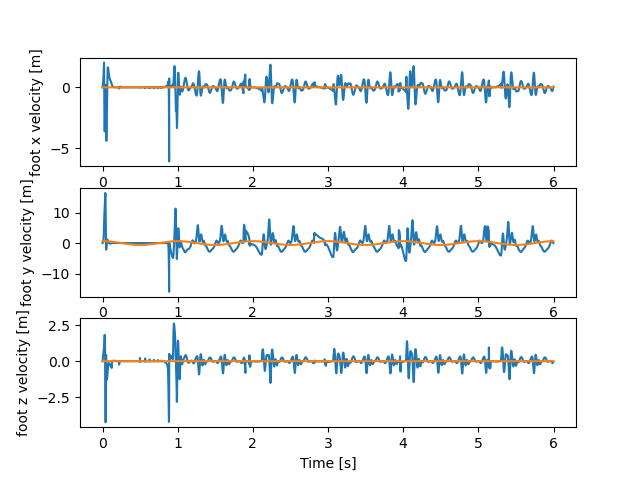

In [6]:
plot_foot_trajectory(simulation_time, foot_measured_position, foot_desired_position, foot_measured_velocity, foot_desired_velocity)